In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Load text helpers
import text_helpers

In [29]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [30]:
sess = tf.Session()

In [31]:
batch_size = 500            # Model Batch Size
embedding_size = 200        # word embedding size
vocabulary_size = 2000      # Maximum vocabulary size
generations = 50000         # number of iterations for training.
model_learning_rate = 0.001 # Learning rate

num_sampled = int(batch_size/2) # Number of negative examples to sample.
window_size = 3                 # How many words to consider left and right.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

In [43]:
import nltk

In [44]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [45]:
# Declare stop words
stops = stopwords.words('english')

# We pick some test words. We are expecting synonyms to appear
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
print('Done.')

Loading Data
Normalizing Text Data
Done.


In [46]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]

Creating Dictionary


In [47]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                               stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together window embeddings:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

Creating Model


In [48]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [49]:
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

In [50]:
# Filter out sentences that aren't long enough:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

In [51]:
# Run the CBOW model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},' .format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 100 : 225.9522705078125
Loss at step 200 : 127.16751861572266
Loss at step 300 : 99.60801696777344
Loss at step 400 : 72.7724838256836
Loss at step 500 : 84.06232452392578
Loss at step 600 : 60.86247253417969
Loss at step 700 : 58.43917465209961
Loss at step 800 : 57.78706359863281
Loss at step 900 : 57.168460845947266
Loss at step 1000 : 64.87226104736328
Loss at step 1100 : 42.18539047241211
Loss at step 1200 : 54.91442108154297
Loss at step 1300 : 54.962989807128906
Loss at step 1400 : 55.350467681884766
Loss at step 1500 : 49.31156921386719
Loss at step 1600 : 53.40127944946289
Loss at step 1700 : 41.203521728515625
Loss at step 1800 : 49.69483947753906
Loss at step 1900 : 37.9473876953125
Loss at step 2000 : 44.91146469116211
Loss at step 2100 : 39.5081787109375
Loss at step 2200 : 40.84773254394531
Loss at step 2300 : 42.71730041503906
Loss at step 2400 : 44.779380798339844
Loss at step 2500 : 45.796539306640625
Loss at step 2600 : 36.1114387512207


Loss at step 17700 : 19.45807647705078
Loss at step 17800 : 17.86587142944336
Loss at step 17900 : 18.790180206298828
Loss at step 18000 : 13.30673599243164
Loss at step 18100 : 12.633423805236816
Loss at step 18200 : 18.253948211669922
Loss at step 18300 : 14.936174392700195
Loss at step 18400 : 15.573580741882324
Loss at step 18500 : 22.952800750732422
Loss at step 18600 : 15.337961196899414
Loss at step 18700 : 18.549108505249023
Loss at step 18800 : 18.597436904907227
Loss at step 18900 : 18.465621948242188
Loss at step 19000 : 12.3530912399292
Loss at step 19100 : 14.635058403015137
Loss at step 19200 : 19.58503532409668
Loss at step 19300 : 17.546573638916016
Loss at step 19400 : 14.390071868896484
Loss at step 19500 : 17.874343872070312
Loss at step 19600 : 14.531120300292969
Loss at step 19700 : 20.47386360168457
Loss at step 19800 : 17.383859634399414
Loss at step 19900 : 17.00252342224121
Loss at step 20000 : 16.162275314331055
Nearest to love: close, RARE, something, dog, re

Loss at step 35000 : 13.62098217010498
Nearest to love: close, something, RARE, reality, dog,
Nearest to hate: poorly, inspired, sex, adolescent, late,
Nearest to happy: levels, wellacted, odd, onto, realism,
Nearest to sad: character, provides, friendship, gripping, live,
Nearest to man: seven, flair, breezy, wasnt, maudlin,
Nearest to woman: birthday, depressing, stuff, lovely, grand,
Model saved in file: C:\Users\Evan\Documents\TensorflowExamples\temp\cbow_movie_embeddings.ckpt
Loss at step 35100 : 8.69277286529541
Loss at step 35200 : 11.299717903137207
Loss at step 35300 : 11.72887134552002
Loss at step 35400 : 9.929064750671387
Loss at step 35500 : 9.556382179260254
Loss at step 35600 : 10.331640243530273
Loss at step 35700 : 9.640328407287598
Loss at step 35800 : 12.934907913208008
Loss at step 35900 : 10.246444702148438
Loss at step 36000 : 9.331050872802734
Loss at step 36100 : 10.651212692260742
Loss at step 36200 : 10.86835765838623
Loss at step 36300 : 14.037959098815918
Lo

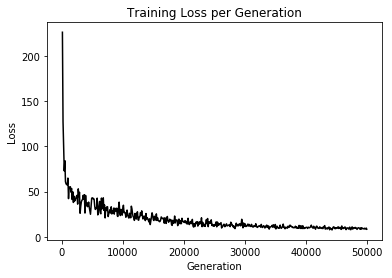

In [52]:
# Plot loss over time
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()